In [4]:
import numpy as np
import torch.nn as nn
import nibabel as nib

In [8]:
data = np.load('../data/2D/ReMIND-034_slice_coronal_110_tumor_label_0.npz')
for key in data.files:
    if np.any(data[key] > 0):
        print(f"Values above 0 found in {key}")
    else:
        print(f"No values above 0 in {key}")

Values above 0 found in data


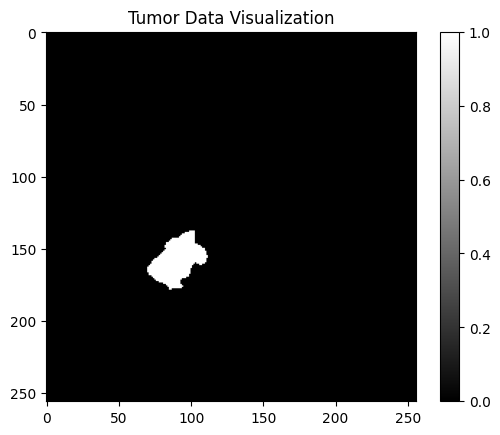

In [9]:
import matplotlib.pyplot as plt

# Load the tumor data from the npz file
tumor_data = data[key]

# Plot the tumor data
plt.imshow(tumor_data, cmap='gray')
plt.title('Tumor Data Visualization')
plt.colorbar()
plt.show()

In [5]:
mask_pre_nifti = nib.load('../data/raw/preop/BTC-preop/derivatives/tumor_masks/sub-PAT06/anat/sub-PAT06_space_T1_label-tumor.nii')
head_pre_nifti = nib.load('../data/processed/preop/BTC-preop/sub-PAT06/t1_ants_aligned.nii.gz')
mask_post_nifti = nib.load('../data/raw/postop/BTC-postop/derivatives/tumor_masks/sub-PAT06/anat/sub-PAT06_space_T1_label-tumor.nii')
head_post_nifti = nib.load('../data/processed/postop/BTC-postop/sub-PAT06/t1_ants_aligned.nii.gz')

In [2]:
def evalExp(gtBin, cur_prob, thres, validMap = None, validArea=None):
    '''
    Does the basic pixel based evaluation!
    :param gtBin: Boolean mask if the pixel is 1 = true in ground truth
    :param cur_prob: the base feature map
    :param thres: array going up to 1
    :param validMap:
    :param validArea: boolean mask where its not 255 = true
    '''

    assert len(cur_prob.shape) == 2, 'Wrong size of input prob map'
    assert len(gtBin.shape) == 2, 'Wrong size of input prob map'
    thresInf = np.concatenate(([-np.Inf], thres, [np.Inf]))
    
    #Merge validMap with validArea
    if np.any(validMap)!=None:
        if np.any(validArea)!=None:
            validMap = (validMap == True) & (validArea == True)
    elif np.any(validArea)!=None:
        validMap=validArea

    # histogram of false negatives
    if np.any(validMap)!=None:
        #valid_array = cur_prob[(validMap == False)]
        fnArray = cur_prob[(gtBin == True) & (validMap == True)]
    else:
        fnArray = cur_prob[(gtBin == True)]
    #f = np.histogram(fnArray,bins=thresInf)
    fnHist = np.histogram(fnArray,bins=thresInf)[0]
    fn_list = list(fnHist)
    fn_sum = sum(fn_list[2:])
    fnCum = np.cumsum(fnHist)
    FN = fnCum[0:0+len(thres)];
    
    if validMap.any()!=None:
        fpArray = cur_prob[(gtBin == False) & (validMap == True)]
    else:
        fpArray = cur_prob[(gtBin == False)]
    
    fpHist  = np.histogram(fpArray, bins=thresInf)[0]
    fpCum = np.flipud(np.cumsum(np.flipud(fpHist)))
    FP = fpCum[1:1+len(thres)]

    # count labels and protos
    #posNum = fnArray.shape[0]
    #negNum = fpArray.shape[0]
    if np.any(validMap)!=None:
        posNum = np.sum((gtBin == True) & (validMap == True))
        negNum = np.sum((gtBin == False) & (validMap == True))
    else:
        posNum = np.sum(gtBin == True)
        negNum = np.sum(gtBin == False)
    return FN, FP, posNum, negNum


In [3]:
def eval_image_rewrite(gt_image, prob,cl_index):
    """
        gt image is the ground truth image
        prob is the binary image feature map
        cl_index is set to 1?
    """
    thresh = np.array(range(0, 256))/255.0 
    cl_gt = gt_image[:,:] == cl_index ## Makes boolean map if the value is 1
    valid_gt = gt_image[:,:] != 255 # makes boolean map if the value is not 255

    FN, FP, posNum, negNum = evalExp(cl_gt, prob,
                                     thresh, validMap=None,
                                     validArea=valid_gt)
    return FN, FP, posNum, negNum